In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import zipfile

import cv2
import numpy as np

from matplotlib import pyplot as plt
import matplotlib.cm as cm

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img

import pickle
from tqdm.notebook import tqdm

import splitfolders
from tensorflow.keras.applications.resnet import ResNet50
import datetime


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
base_path = '/content/drive/MyDrive/image_recognition/data/image_data/img/'

In [ ]:
with zipfile.ZipFile(base_path + 'blepharitis.zip', 'r') as zip_ref:
  zip_ref.extractall('/content')

In [ ]:
splitfolders.ratio('/content/blepharitis', output = 'blepharitis_dataset', seed = 77, ratio = (0.8, 0.1, 0.1))

Copying files: 13759 files [00:02, 6140.36 files/s]


## Zero-Centering

In [ ]:
train_path = '/content/blepharitis_dataset/train'
img_paths = []
for label in os.listdir(train_path):
  sub_path = train_path + '/' + label + '/'
  for files in os.listdir(sub_path):
    img_paths.append(sub_path + files)


In [ ]:
X_train = []

for img_file in img_paths:
  img = cv2.imread(img_file)
  X_train.append(img)

In [ ]:
compute_mean = lambda imgs: np.mean(imgs, axis = 0)
mean_img = compute_mean(X_train)
sub_mean_img = lambda image: image - mean_img

In [ ]:
batch_size = 128

In [ ]:
train_datagen = ImageDataGenerator(preprocessing_function=sub_mean_img)
val_datagen = ImageDataGenerator(preprocessing_function=sub_mean_img)
test_datagen = ImageDataGenerator(preprocessing_function=sub_mean_img)

In [ ]:
train_generator = train_datagen.flow_from_directory('/content/blepharitis_dataset/train', batch_size=batch_size, target_size=(224, 224), class_mode = 'binary')
val_generator = val_datagen.flow_from_directory('/content/blepharitis_dataset/val', batch_size=batch_size, target_size=(224, 224), class_mode = 'binary')
test_generator = test_datagen.flow_from_directory('/content/blepharitis_dataset/test', batch_size=batch_size, target_size=(224, 224), class_mode = 'binary')

Found 11007 images belonging to 2 classes.
Found 1375 images belonging to 2 classes.
Found 1377 images belonging to 2 classes.


In [ ]:
base_model_50 = ResNet50(include_top = False, input_shape = (224, 224, 3), weights = 'imagenet')

base_model_50.trainable = True

for layer in base_model_50.layers[:-10]:
  layer.trainable = False

inputs = tf.keras.Input(shape= (224, 224, 3))

x = base_model_50(inputs, training = False)
x = tf.keras.layers.Flatten(input_shape=base_model_50.output_shape[1:])(x)
x = tf.keras.layers.Dense(256, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
s_model_res50_zero = tf.keras.Model(inputs, outputs)


94765736/94765736 [==============================] - 4s 0us/step


In [ ]:
s_model_res50_zero.compile(optimizer='adam', loss= 'binary_crossentropy', metrics = ['accuracy', 'Recall'])

In [ ]:
# tensorboard log 저장
model_name = 'blepharitis_ZeroCentering'
current_time = datetime.datetime.now().strftime("%m%d%H%M") # Y : 연도 / m : 월 / d : 일 / H : 시 / M : 분 / S : 초
current_time

'03270601'

In [ ]:
log_dir = "/content/drive/MyDrive/image_recognition/ayun/logs/ZeroCentering/" + current_time + model_name
board = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=2) # epoch마다 히스토그램 계산
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights = True) # EarlyStooping , restore_best_weights = True 가장 성능이 좋았을때 

history = s_model_res50_zero.fit(train_generator, validation_data = val_generator, epochs = 100, callbacks=[board, early]) # 콜백 전달

Epoch 1/100
86/86 [==============================] - 68s 592ms/step - loss: 1.8211 - accuracy: 0.9254 - recall: 0.9168 - val_loss: 0.0328 - val_accuracy: 0.9884 - val_recall: 0.9869
Epoch 2/100
86/86 [==============================] - 42s 480ms/step - loss: 0.0677 - accuracy: 0.9796 - recall: 0.9731 - val_loss: 0.0339 - val_accuracy: 0.9898 - val_recall: 0.9971
Epoch 3/100
86/86 [==============================] - 47s 545ms/step - loss: 0.0292 - accuracy: 0.9912 - recall: 0.9898 - val_loss: 0.0179 - val_accuracy: 0.9920 - val_recall: 0.9840
Epoch 4/100
86/86 [==============================] - 42s 489ms/step - loss: 0.0166 - accuracy: 0.9945 - recall: 0.9920 - val_loss: 0.0106 - val_accuracy: 0.9978 - val_recall: 0.9971
Epoch 5/100
86/86 [==============================] - 47s 538ms/step - loss: 0.0222 - accuracy: 0.9941 - recall: 0.9931 - val_loss: 0.0149 - val_accuracy: 0.9942 - val_recall: 0.9971
Epoch 6/100
86/86 [==============================] - 42s 487ms/step - loss: 0.0318 - accur

In [ ]:
s_model_res50_zero.evaluate(test_generator)

11/11 [==============================] - 6s 562ms/step - loss: 0.0167 - accuracy: 0.9964 - recall: 0.9927


[0.016711687669157982, 0.996368944644928, 0.992732584476471]

In [ ]:
# 모델 저장 경로 및 파일명 지정
model_path = '/content/drive/MyDrive/image_recognition/js/model/blepharitis_zero.h5'

# 모델 저장
s_model_res50_zero.save(model_path)

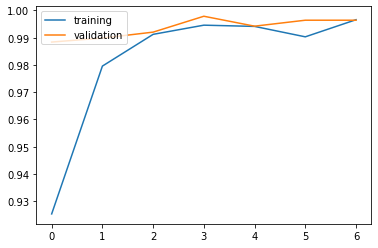

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'], loc = 'upper left')
plt.show()

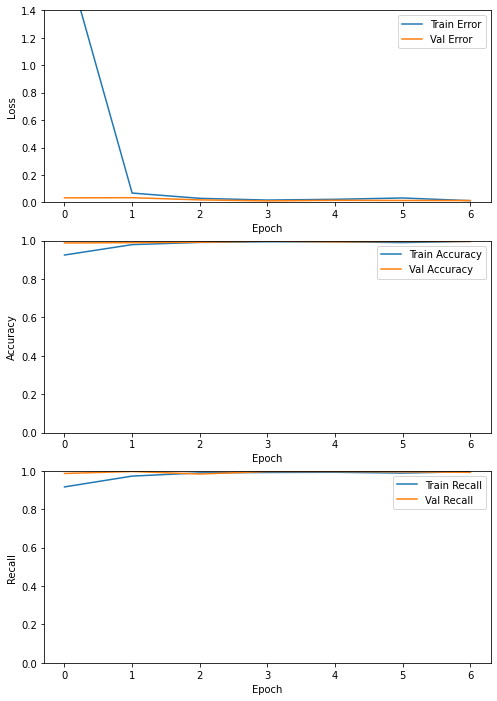

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure(figsize=(8,12))

  plt.subplot(3,1,1)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val Error')
  plt.ylim([0,1.4])
  plt.legend()
  
  plt.subplot(3,1,2)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Accuracy')
  plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Accuracy')
  plt.ylim([0,1])
  plt.legend()

  plt.subplot(3,1,3)
  plt.xlabel('Epoch')
  plt.ylabel('Recall')
  plt.plot(hist['epoch'], hist['recall'],
           label='Train Recall')
  plt.plot(hist['epoch'], hist['val_recall'],
           label = 'Val Recall')
  plt.ylim([0,1])
  plt.legend()
  plt.show()

plot_history(history)